# `AA Workshop 13` — Coding Challenge

Complete the tasks below to practice time series techniques from `W13_Time_Series.ipynb`.

Guidelines:
- Work in order. Run each cell after editing with Shift+Enter.
- Keep answers short; focus on making things work.
- If a step fails, read the error and fix it.

By the end you will have exercised:
- checking if a time series is stationary
- determining p, d and q of an ARIMA model
- training and evaluating an ARIMA model
- generating time series predictions

## Task 1 - Predicting U.S. Real GDP

Let's put what we have learned about time-series forecasting into practice. For this task, we aim to predict U.S. Real GDP. You can load the data as follows:

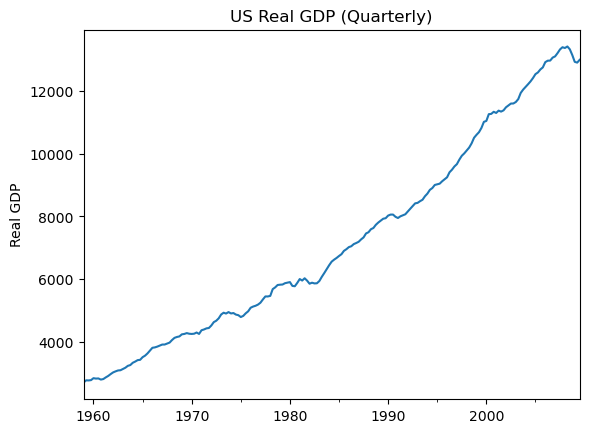

In [1]:
from statsmodels.datasets import macrodata
import pandas as pd
import matplotlib.pyplot as plt

# load macroeconomic dataset
data = macrodata.load_pandas().data

# create a quarterly datetime index
dates = pd.period_range(
    start=f"{int(data.year.iloc[0])}Q{int(data.quarter.iloc[0])}",
    periods=len(data),
    freq="Q"
)
data.index = dates.to_timestamp()

ts = data["realgdp"]

ts.plot(title="US Real GDP (Quarterly)")
plt.ylabel("Real GDP")
plt.show()

Complete the following steps:
- **Determine d**: ARIMA models require stationary time series. Check whether the time-series is stationary using the Augmented Dickey-Fuller test. If not, apply differencing and check again.
- **Determine p & q**: Generate ACF and PACF plots of the stationary series to determine possible values for p & q.
- **Train & evaluate ARIMA models**: train and evaluate ARIMA models with potentially suitable values for p, d & q. Remember to perform a train/test split (note that our usual approach of randomly splitting data points into train and test sets does not work with time-series data. Instead, you might want to check out https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).
- **Generate predictions**: Plot true and predicted values generated by your best performing model.

### Determine d

In [2]:
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [3]:
# Augmented Dickey-Fuller test on original series
adf_level = adfuller(ts)
print(f"ADF p-value (level): {adf_level[1]:.4f}")

ADF p-value (level): 0.9982


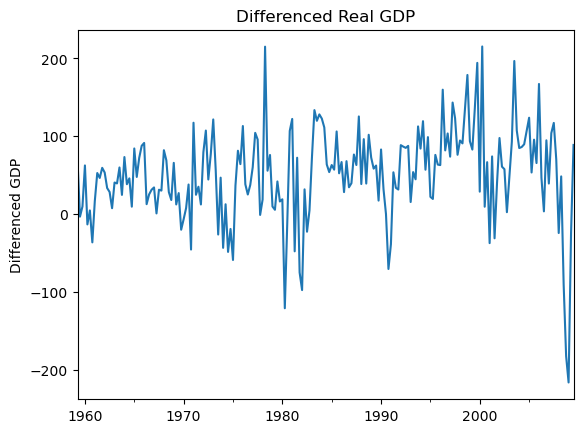

In [4]:
# first-order differencing
ts_diff = ts.diff().dropna()

ts_diff.plot(title="Differenced Real GDP")
plt.ylabel("Differenced GDP")
plt.show()

In [5]:
# ADF test on differenced series
adf_diff = adfuller(ts_diff)
print(f"ADF p-value (differenced): {adf_diff[1]:.4f}")

ADF p-value (differenced): 0.0000


### Determine p & q

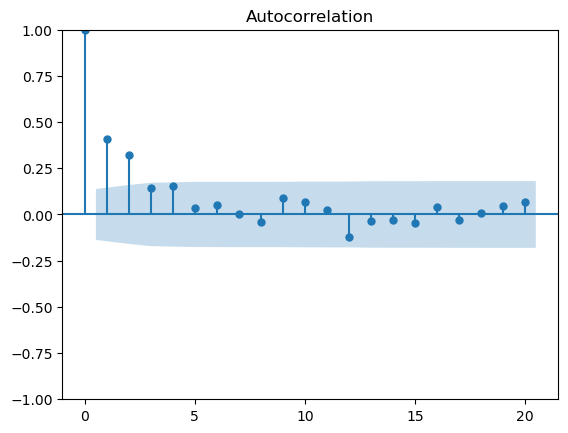

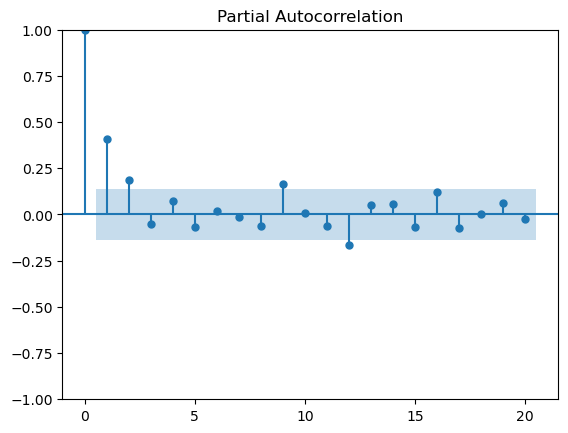

In [6]:
plot_acf(ts_diff, lags=20)
plot_pacf(ts_diff, lags=20)
plt.show()

### Train & evaluate ARIMA models

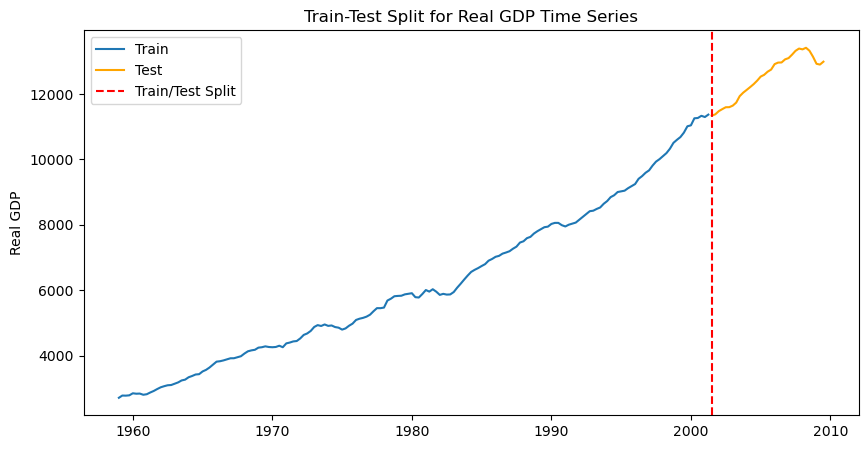

In [7]:
# perform train/test split
tscv = TimeSeriesSplit(n_splits=5)

train_idx, test_idx = list(tscv.split(ts))[-1]
train, test = ts.iloc[train_idx], ts.iloc[test_idx]

plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.axvline(test.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.legend()
plt.title("Train-Test Split for Real GDP Time Series")
plt.ylabel("Real GDP")
plt.show()

In [8]:
candidate_models = [
    (1, 1, 0),
    (1, 1, 1),
    (2, 1, 0),
    (2, 1, 1),
    (3, 1, 1)
]

In [9]:
results_summary = []

for order in candidate_models:
    # train model
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    
    # predict
    forecast = fitted_model.forecast(steps=len(test))
    
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    # save results
    results_summary.append({
        "order": order,
        "rmse": rmse,
        "forecast": forecast
    })
    
    print(f"ARIMA{order} RMSE: {rmse:.2f}")

ARIMA(1, 1, 0) RMSE: 1209.64
ARIMA(1, 1, 1) RMSE: 691.32
ARIMA(2, 1, 0) RMSE: 1163.98
ARIMA(2, 1, 1) RMSE: 320.51
ARIMA(3, 1, 1) RMSE: 237.79


In [10]:
# save best performing model
best_model = min(results_summary, key=lambda x: x["rmse"])
best_order = best_model["order"]
best_forecast = best_model["forecast"]

print(f"\nBest ARIMA model: ARIMA{best_order}")
print(f"Best RMSE: {best_model['rmse']:.2f}")


Best ARIMA model: ARIMA(3, 1, 1)
Best RMSE: 237.79


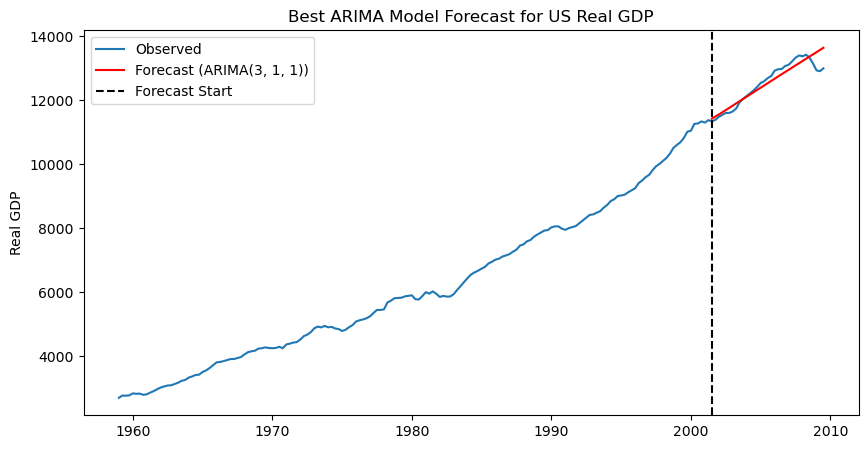

In [11]:
# plot predictions
plt.figure(figsize=(10,5))
plt.plot(ts, label="Observed")
plt.plot(best_forecast, label=f"Forecast (ARIMA{best_order})", color="red")
plt.axvline(test.index[0], color="black", linestyle="--", label="Forecast Start")
plt.legend()
plt.title("Best ARIMA Model Forecast for US Real GDP")
plt.ylabel("Real GDP")
plt.show()

**Note: Why does the forecast look like a straight line?**

You might notice that your ARIMA forecast for U.S. GDP looks like a steady, upward-sloping straight line. This is actually a sign that the model is working correctly!

By differencing the data ($d=1$), we are modeling the quarterly change (growth) rather than the absolute level. Since U.S. GDP tends to grow at a relatively steady average rate over long periods, the ARIMA model identifies this average growth (the drift/intercept) and projects it forward.

While real-world GDP has small quarterly fluctuations, the model’s job is to revert to the historical mean growth rate over the long term, resulting in a stable, linear projection of the economy’s path.

-----------------------